# Preliminary Analysis
In this notebook, we will validate the behavior of all functions to ensure they work as expected. We will also verify what can be simplified or neglected during the dimensioning process (handled in a separate notebook).

In [2]:
# 3rd Party Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import math
from IPython.display import display, Math

# Internal Libraries
import functions as f
import nuclei_func as nf
from functions import Material_Proprieties

## Input Data

All material proprietes (Fuel, Helium, Cladding and Coolant) are saved in a custom defined class to avoid repeatedly passing many parameters to functions, reducing complexity and improving code readability and maintainability.

In [3]:
# Material: Cladding
# 15-15, Ti stabilized, cold worked stainless steel
Cladding_mat_prop = Material_Proprieties(
    Elements=["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
    Qualities=[15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
    Density=lambda eth: 7900 * (1 + eth)**-3,  # kg/m^3
    Thermal_Conductivity=lambda t: 13.95 + 0.01163 * t,  # W/m K
    Thermal_Expansion_Coeff=lambda t: -3.101e-4 + 1.545e-5 * t + 2.75e-9 * t**2,  # 1/°C
    Specific_Heat=500,  # Approximate value in J/kg K for steel
    Melting_Temperature=1673,  # K
    Youngs_Modulus=lambda t: 202.7 - 0.08167 * t,  # GPa
    Poissons_Ratio=lambda t: 0.277 + 6e-5 * t,  # Dimensionless
    Yield_Stress=lambda t: 555.5 - 0.25 * t if t < 600 else (405.5 - 0.775 * (t - 600) if t < 1000 else 345.5 - 0.25 * t),  # MPa
    Ultimate_Tensile_Strength=lambda t: 700 - 0.3125 * t if t < 600 else (512.5 - 0.969 * (t - 600) if t < 1000 else 437.5 - 0.3125 * t),  # MPa
)

# Material: Fuel
# Homogeneous MOX fuel
# Qualities have to be converted from weight to molar:
mol_qual = nf.w2mol([0.711, 0.29], [235.0439299, 238.05078826])  # U-235, U-238
Fuel_mat_prop = Material_Proprieties(
    Elements=["U-235", "U-238", "O-16", "Pu"],
    Qualities=[mol_qual[0] * (1 - mol_qual[1]), (1 - mol_qual[0]) * (1 - mol_qual[1]), 2, mol_qual[1]],  # To fix since 0.29 is in weight
    Density=11.31*94.5/100,  # g/cm^3
    Molar_Mass=[235.0439299, 238.05078826, 15.99491461956, 244.064204],  # g/mol
    Micro_Fission=[1.047756375, 0.55801001, 0, 1.689844625],  # barns
    Thermal_Conductivity=lambda k_inf, beta: 1.755 + (k_inf - 1.755) * math.exp(-beta),  # W/m K
    Thermal_Expansion_Coeff=1.2e-5,  # 1/°C
    Specific_Heat=270,  # Approximate value in J/kg K for MOX fuel
    Melting_Temperature=lambda pu, x, beta: 2964.92 + ((3147 - 364.85 * pu - 1014.15 * x) - 2964.92) * math.exp(-beta),  # K
    Youngs_Modulus=lambda t, p: (22.43 * 10**4 - 31.19 * t) * (1 - 2.6 * p),  # MPa
    Poissons_Ratio=0.32,  # Dimensionless
)

# Material: Coolant (Sodium)
Coolant_mat_prop = Material_Proprieties(
    Elements=["Na"],
    Qualities=[1],
    Density=lambda t: 954.1579 + ((t-273) * 9/5 +32) *( ((t-273) * 9/5 +32) * ((((t-273) * 9/5 +32) * 0.9667e-9 - 0.46e-5)) - 0.1273534),  # kg/m^3 (t * 9/5 +32) is the convertion from C to K to F
    Viscosity=lambda t: (math.exp(813.9 / t -2.530 ))/1000,  # Pa s
    Thermal_Conductivity=lambda t: 110 - 0.0648 * t + 1.16e-5 * t**2,  # W/m K
    Specific_Heat=lambda t: 1608 - 0.7481 * t + 3.929e-4 * t**2,  # J/kg K
    Melting_Temperature=98,  # °C
    Boiling_Temperature=882,  # °C
    Nusselt_Number=lambda pe: 7 + 0.025 * pe**0.8
)

# Material: Helium (Filling Gas)
Helium_mat_prop = Material_Proprieties(
    Elements=["He"],
    Qualities=[1],
    Density=0.1786,  # kg/m^3 at STP
    Thermal_Conductivity=lambda t: 15.8e-4 * t**0.79,  # W/m K
    Specific_Heat=5193,  # J/kg K at constant pressure
    Thermal_Expansion_Coeff=3.66e-3  # Approximate value for helium in 1/°C
)


Computed secondary data

In [4]:
# Energy per Fission
E_fission = nf.mixture([200, 205, 0, 210], Fuel_mat_prop.Qualities)  # MeV
display(Math(r'E_{fission} = %.2f \, \text{MeV}' % E_fission))

The sum of the qualites values is not 1, default behaviour is ignoring.


<IPython.core.display.Math object>

Other data is saved as common variables

In [5]:
# Data for Fuel Pin Specifications
q_linear_avg = 38.7  #kW/m
fuel_column_height = 850  # mm
fuel_pellet_outer_diameter = 5.42  # mm
fuel_pellet_height = 7  # mm
fuel_theoretical_density = 11.31  # g/cm^3
fuel_density_percent_td = 94.5  # %
fuel_grain_diameter = 10  # μm
oxygen_to_metal_ratio = 1.957

cladding_outer_diameter = 6.55  # mm
initial_pressure_filling_gas = 0.1  # MPa
initial_temperature_filling_gas = 20  # °C

# Data for Neutronic Specifications
neutron_flux_peak = 6.1e15  # Neutron Flux (> 100 keV) (10^15 n cm^-2 s^-1) at Peak Power Node

# Data for Thermo-Hydraulic Specifications
pin_pitch = 8.275  # mm
coolant_inlet_temp = 395  # °C
coolant_inlet_pressure = 0.1  # MPa
coolant_mass_flow_rate = 0.049  # kg/s

# Data for Axial Nodalization of the Fuel Pin
node_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5]  # mm
peak_factors = [0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498]

Verification parameters that will be needed for dimensioning

In [6]:
# Data for Indicative Design Limits
max_fuel_temp = 2600  # °C
max_cladding_temp = 650  # °C
max_plenum_pressure = 5  # MPa
max_cladding_plastic_strain = 0.5  # %
max_cladding_swelling = 3  # %
max_coolant_velocity = 8  # m/s

## Thermal - Hydraulics Analysis

In [7]:
Temperaure_Preliminary = coolant_inlet_temp + 273  # K
display(Math(r'T_{\text{Preliminary}} = %s \, \text{K}' % Temperaure_Preliminary))

<IPython.core.display.Math object>

In [8]:
#Preliminary check of coolant properties

density = Coolant_mat_prop.Density(Temperaure_Preliminary)
viscosity = Coolant_mat_prop.Viscosity(Temperaure_Preliminary)
thermal_conductivity = Coolant_mat_prop.Thermal_Conductivity(Temperaure_Preliminary)
c_p = Coolant_mat_prop.Specific_Heat(Temperaure_Preliminary)

display(Math(r'\rho_{coolant} =' + f'{density:.2f}' + r'\text{ kg/m}^3' ))
display(Math(r'\mu_{coolant} =' + f'{viscosity*1000:.2f}' + r'\text{ mPa s}' ))
display(Math(r'k_{coolant} =' + f'{thermal_conductivity:.2f}' + r'\text{ W/m K}' ))
display(Math(r'c_p =' + f'{c_p:.2f}' + r'\text{ J/kg K}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
# Velocity and Passage Area Calculation
# To be modified with a proper evaluation

velocity, passage_area, d_h = f.hydraulic_flow(coolant_mass_flow_rate, pin_pitch*1e-3, cladding_outer_diameter*1e-3, Coolant_mat_prop, Temperaure_Preliminary)

display(Math(r'v_{coolant} =' + f'{velocity:.2f}' + r'\text{ m/s}' ))
display(Math(r'A_{passage} =' + f'{passage_area*1e6:.2f}' + r'\text{ mm}^2' ))
display(Math(r'D_{hydr} =' + f'{d_h:}' + r'\text{ m}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

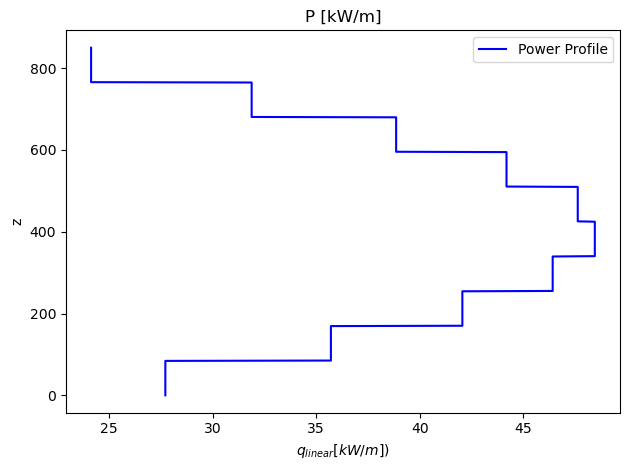

In [11]:
h_values = np.linspace(0, 850, 1000)
q_values = [f.power_profile_step(h, heights_of_slice_centre, peak_factors, q_linear_avg) for h in h_values]

# Create a figure with one subplot
fig, (power1) = plt.subplots(1)

# Plot the power profile
power1.plot(q_values, h_values, label='Power Profile', color='blue')

# Set title and axis labels
power1.set_title(r'P [kW/m]')
power1.set_xlabel(r'$q_{linear} [kW/m]$')
power1.set_ylabel(r'z')

# Add legend to the plot
power1.legend()

# Adjusts spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()

In [141]:
# Computing the Heat Transfer Coefficient between the Coolant and the cladding
htc, reynolds, prandtl, peclet, nusselt, d_h = f.heat_trans_coefficient(cladding_outer_diameter*1e-3, coolant_mass_flow_rate, pin_pitch*1e-3, Coolant_mat_prop, Temperaure_Preliminary)
# Display the heat transfer coefficient
display(Math(r'\alpha_{cladding - coolant} =' + f'{htc*1e-3:.2f}' + r'\text{ kW/m}^2\text{K}'))
display(Math(r'Re =' + f'{reynolds}'))
display(Math(r'Pe =' + f'{peclet}' ))
display(Math(r'Pr =' + f'{prandtl}' ))
display(Math(r'D_{h} =' + f'{d_h}' ))
display(Math(r'Nu =' + f'{nusselt}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### Linee guida da chatGPT:  

Verification
Margin to Melting of the Fuel
Code to verify that the fuel temperature remains below the limit.

Temperature of the Cladding
Code for cladding temperature calculations.

Yielding of the Cladding
Code to determine the safety against yielding based on stress analysis.

Time to Rupture for Thermal Creep of the Cladding
Calculation and analysis of thermal creep failure time.

Considerations for Double Irradiation Time
Identify critical aspects to be considered if the irradiation time is doubled.

Results Visualization
Create plots where necessary, for example:
- Temperature profiles
- Creep stress against time